# AllLife Bank Customer Segmentation

## Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

## Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%reload_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

<IPython.core.display.Javascript object>

In [2]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

* The dataset has 660 rows and 7 columns 

In [4]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [5]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

In [6]:
# let's look at the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

**We won't need S1_No and Customer Key for analysis, so let's drop this column.**

In [7]:
df.drop("Customer Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [8]:
df.drop("Sl_No", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
# let's check for duplicate observations
df.duplicated().sum()

11

<IPython.core.display.Javascript object>

- There are 11 duplicate observations. We will remove them from the data.

In [10]:
df = df[(~df.duplicated())].copy()

<IPython.core.display.Javascript object>

**Let's look at a summary of the data**

In [11]:
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,649.000000,649.000000,649.000000,649.000000,649.000000
mean,34878.274268,4.708783,2.397535,2.624037,3.590139
std,37813.736638,2.173763,1.625148,2.952888,2.877911
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,11000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,49000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


<IPython.core.display.Javascript object>

**Observations**

- The average credit limit is 34,878.
- The average total number of credit cards is 4.7.
- The average total visits to the bank is 2.3.
- The average total visits online is 2.62.
- The average total of calls made is 3.5.

In [12]:
# checking missing values
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

- There are no missing values in the data.

## EDA

In [13]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

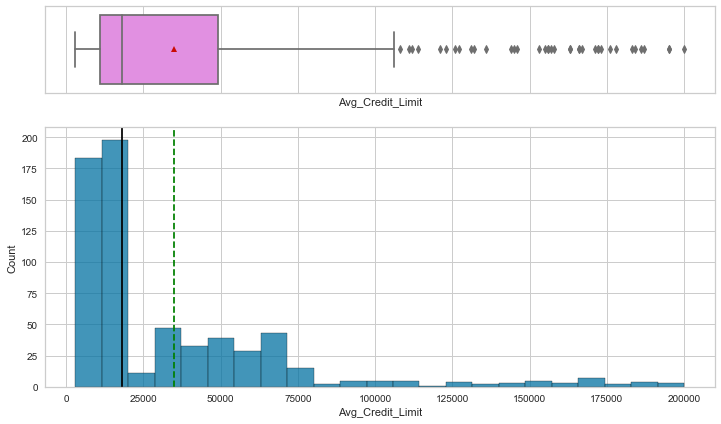

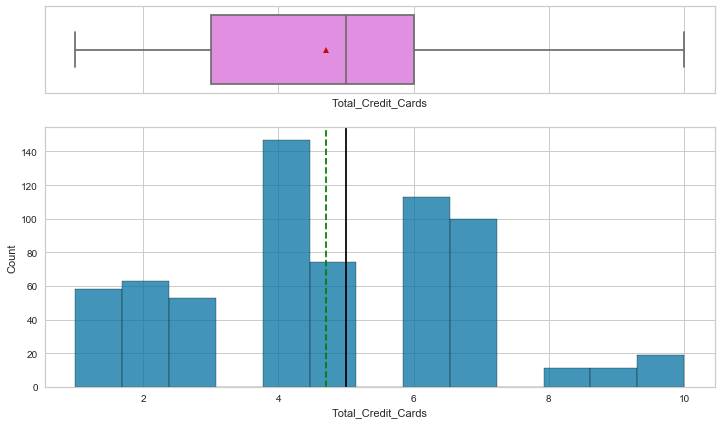

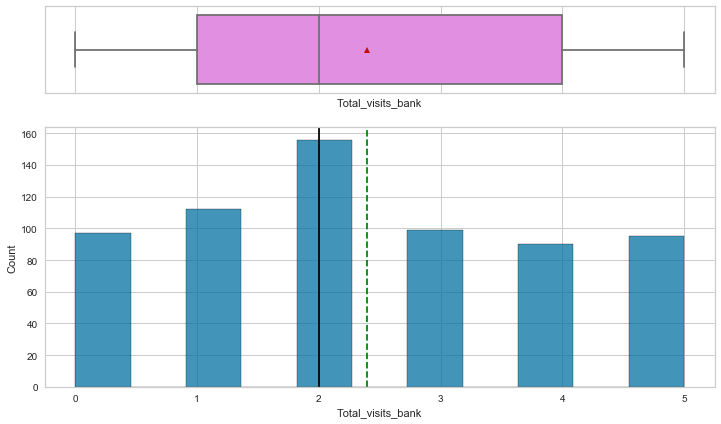

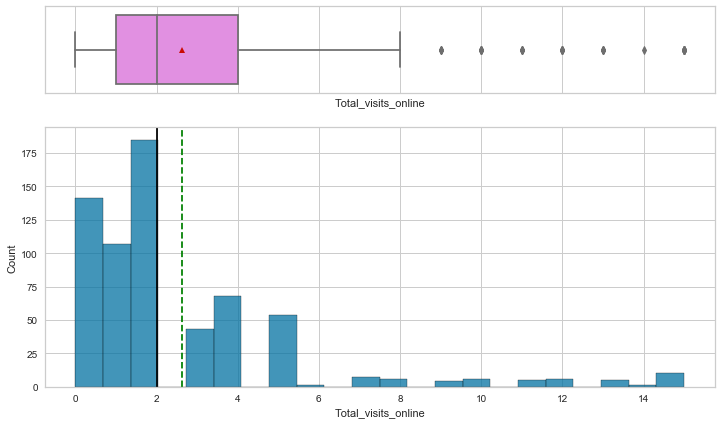

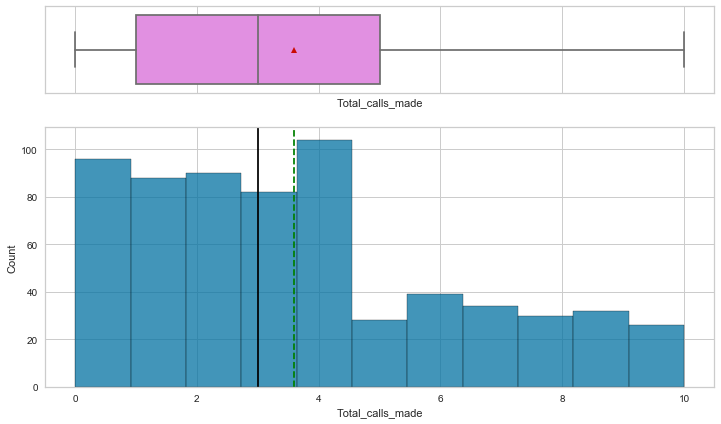

<IPython.core.display.Javascript object>

In [14]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

**Observations**

- Average credit limit has right-skewed distributions with upper outliers, which indicates the presence of some high credit limits.
- Total number of credit cards has a wide range from 2 to 10. 
- Total visit to the bank is also evenly distrubited between 0 and 5. 
- Total visits online has right-skewed distributions with upper outliers, which also indicates the presence of high visits online. 
- Total calls made is right skewed and most of the total calls made is 4. 

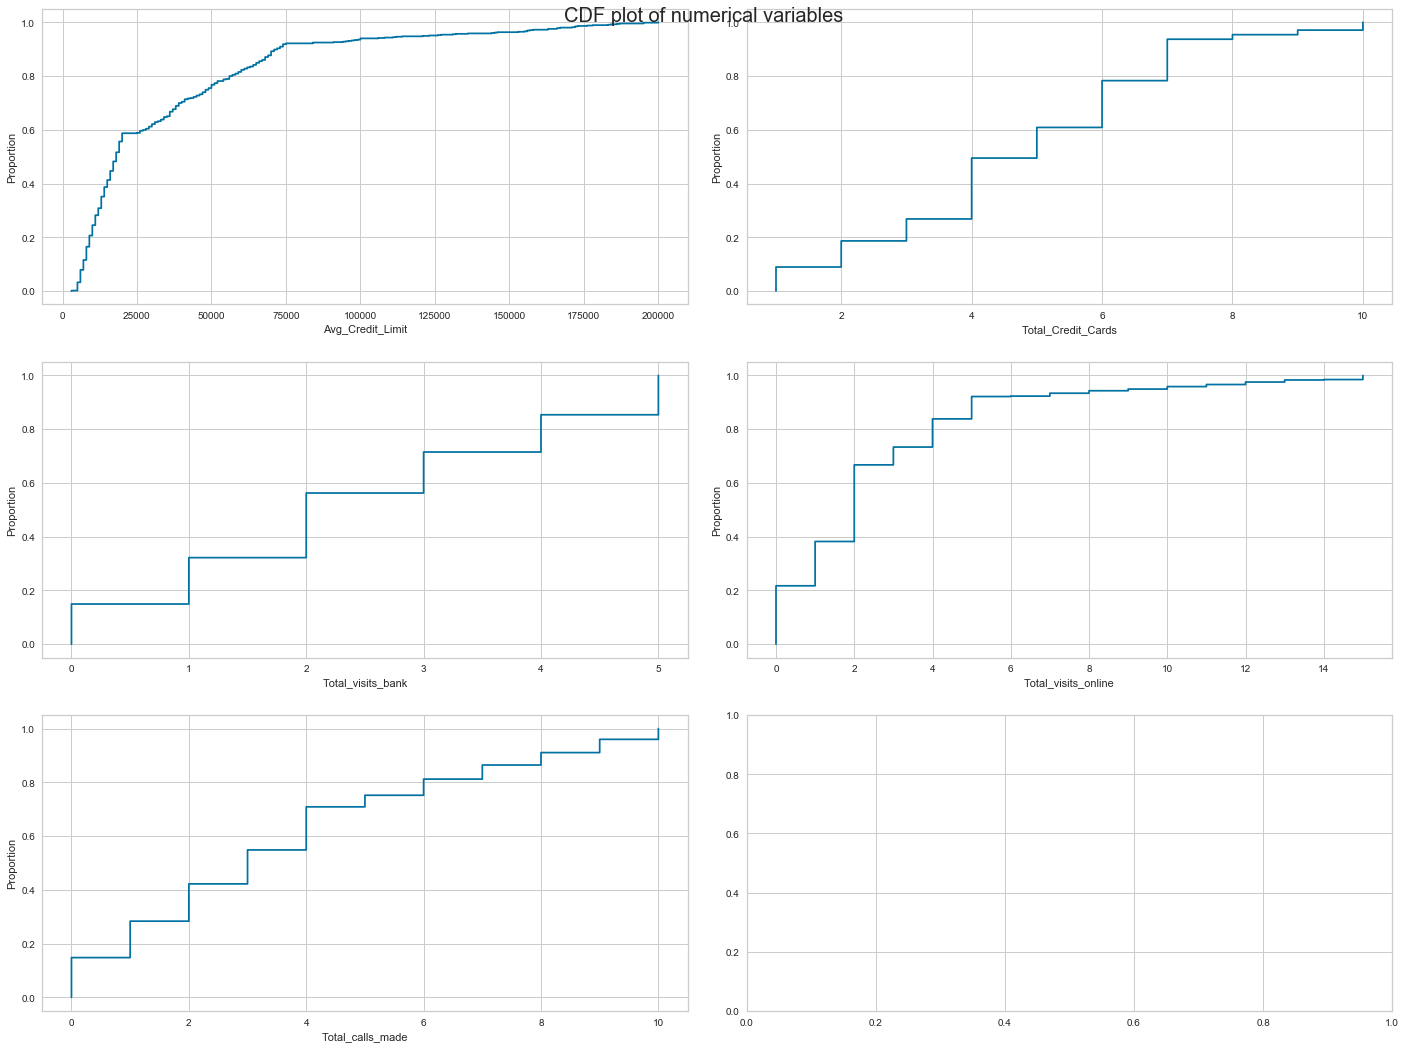

<IPython.core.display.Javascript object>

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- 60% of customers have have an average credit limit of $25,000.
- 80% of customers have 6 credit cards. 
- 80% of customers have at least 4 visits to the bank
- 80% of customer have made at least 4 calls to the bank. 

In [16]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

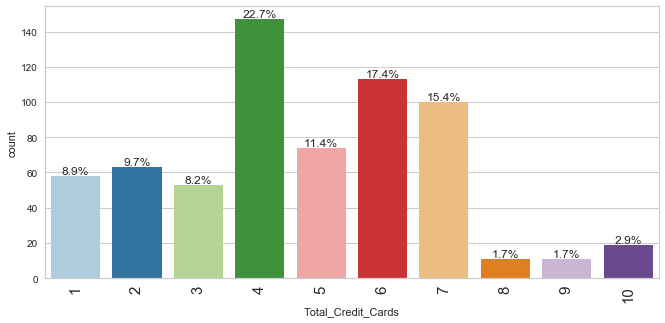

<IPython.core.display.Javascript object>

In [17]:
# let's explore average credit limit further
labeled_barplot(df, "Total_Credit_Cards", perc=True)

**Observations**

- All customers in this data set have credit cards
- 22.7% of customers have at least 4 credit cards
- Only 2.9% of customers have 10 credit cards.

## Bivariate Analysis


**Let's check for correlations.**

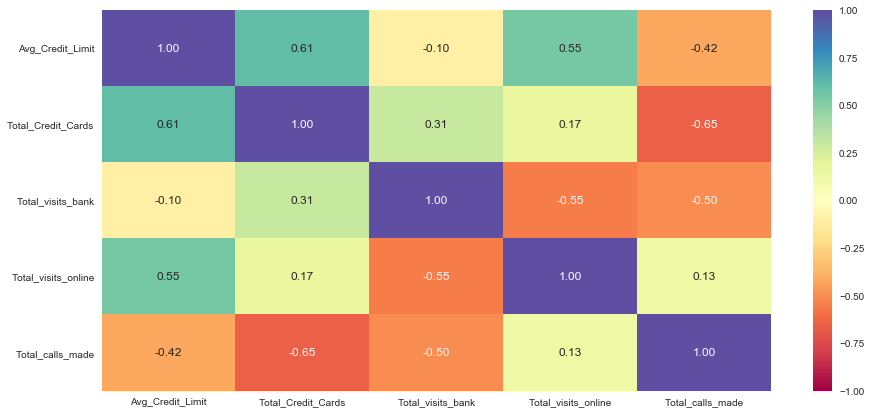

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

- The average credit limit and total number of credit cards are highly positively correlated, which is obvious.
- Total visits online has medium correlation with the average credit limit which is interesting.  
- Total credit cards is somewhat negativly correlated with total credit cards which indicates that customers who make fewer calls to the bank tend to have less total credit cards. 

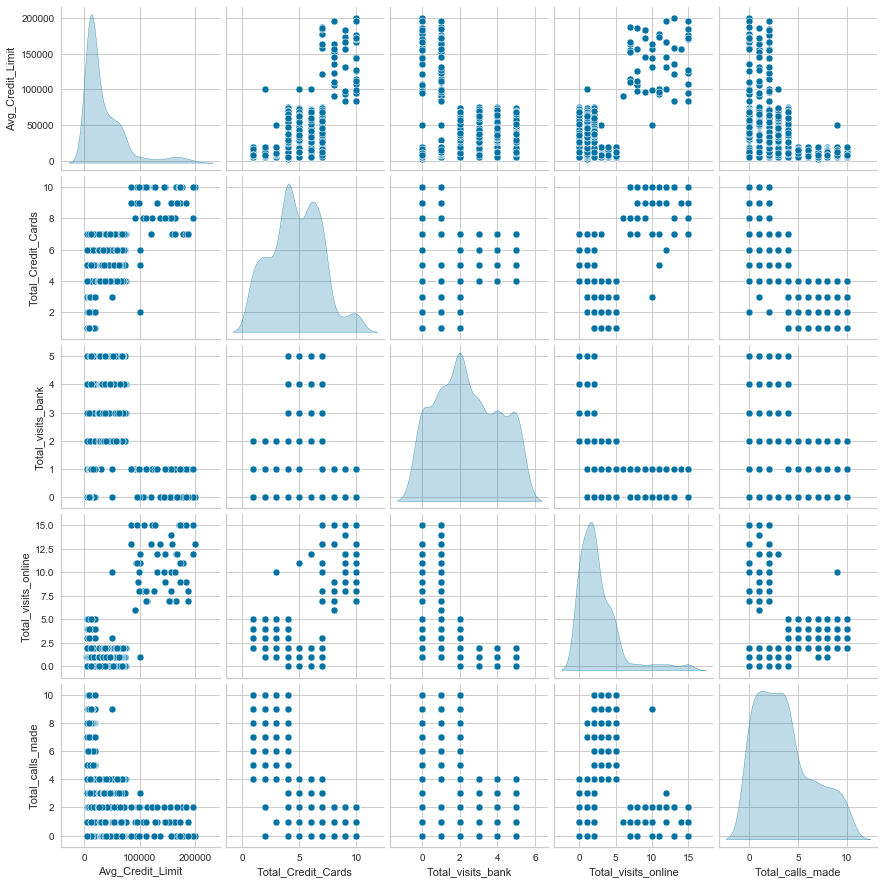

<IPython.core.display.Javascript object>

In [19]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- Most visits online are less than 5. 
- Total calls made to the bank are greater for those with higher average credit limits. .

## Data Preprocessing

In [20]:
# variables used for clustering
num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

In [21]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [22]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

## K-Means Clustering

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077824
Number of Clusters: 3 	Average Distortion: 1.1434401208195093
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.9877797835028077
Number of Clusters: 6 	Average Distortion: 0.9402321120333814
Number of Clusters: 7 	Average Distortion: 0.9079350767731129
Number of Clusters: 8 	Average Distortion: 0.8941097424457203


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

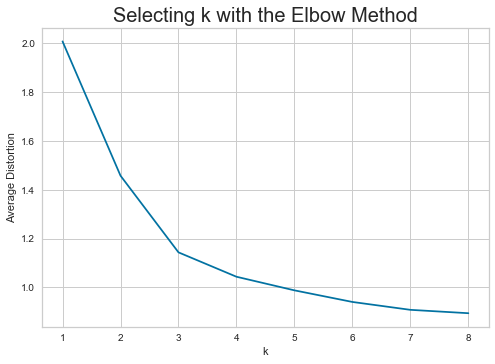

<IPython.core.display.Javascript object>

In [23]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 3 or 4.**

**Let's check the silhouette scores.**



For n_clusters = 2, silhouette score is 0.41800025566689647
For n_clusters = 3, silhouette score is 0.516281010855363
For n_clusters = 4, silhouette score is 0.3570238219413198
For n_clusters = 5, silhouette score is 0.2722848313346344
For n_clusters = 6, silhouette score is 0.2569035285862428
For n_clusters = 7, silhouette score is 0.24825112050393752
For n_clusters = 8, silhouette score is 0.22671810718687038
For n_clusters = 9, silhouette score is 0.2217695310749938


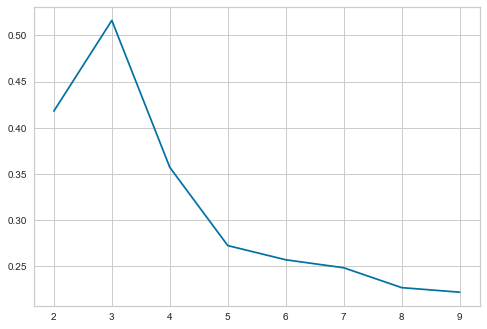

<IPython.core.display.Javascript object>

In [24]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 7 is a good value of k.**



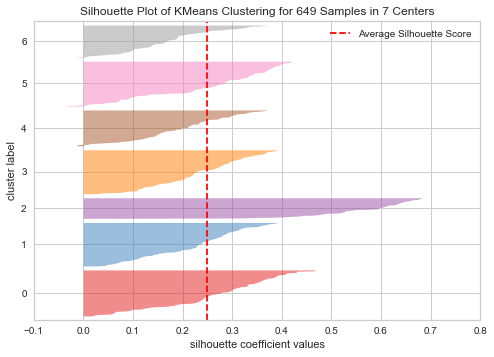

<IPython.core.display.Javascript object>

In [25]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

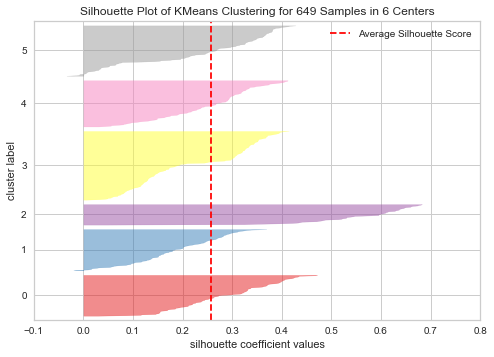

<IPython.core.display.Javascript object>

In [26]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Let's take 4 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 4 in the elbow curve.

In [27]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>

In [28]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [29]:
cluster_profile = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [30]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [31]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,35857.142857,5.525510,2.479592,0.974490,2.056122,196
1,12233.944954,2.394495,0.940367,3.582569,6.944954,218
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,31832.432432,5.481081,4.513514,1.005405,1.940541,185


<IPython.core.display.Javascript object>

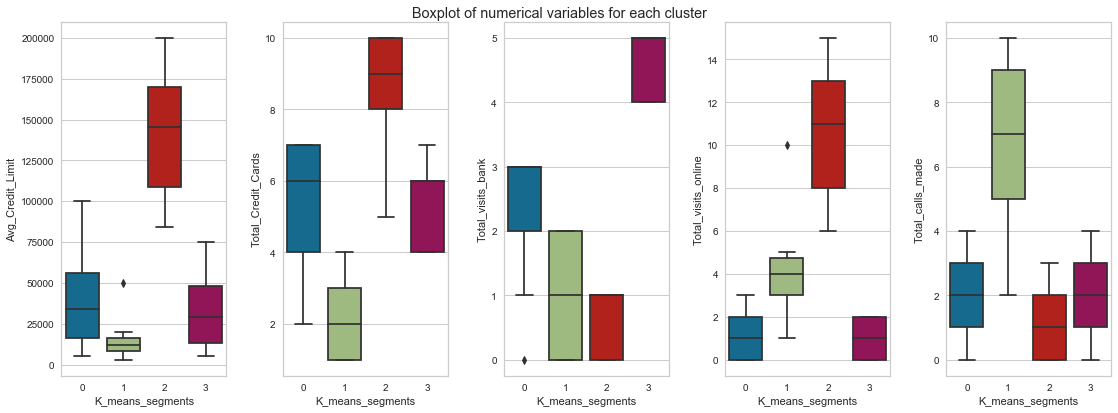

<IPython.core.display.Javascript object>

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Hierarchical Clustering

In [33]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7395135051413775.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8794736468795109.
Cophenetic correlation for Euclidean distance and average linkage is 0.8974425535306298.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8551098644586315.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7379112982920528.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8578617029322211.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8960370054789858.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.893309534644998.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7054746377393304.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6513369047977703.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.833028569226309.
Cophenetic corr

<IPython.core.display.Javascript object>

In [34]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8974425535306298, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

**Let's explore different linkage methods with Euclidean distance only.**

In [35]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7395135051413775.
Cophenetic correlation for complete linkage is 0.8794736468795109.
Cophenetic correlation for average linkage is 0.8974425535306298.
Cophenetic correlation for centroid linkage is 0.894471288720818.
Cophenetic correlation for ward linkage is 0.7425813590948763.
Cophenetic correlation for weighted linkage is 0.8551098644586315.


<IPython.core.display.Javascript object>

In [36]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8974425535306298, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**Observations**

- We see that the cophenetic correlation is maximum with cityblock distance, which is the Manhattan distance, and average linkage.
- The cophenetic correlation with Euclidean distance and average linkage is just barely less than the combination with maximum cophenetic correlation. 


**Let's see the dendrograms for the different linkage methods.**

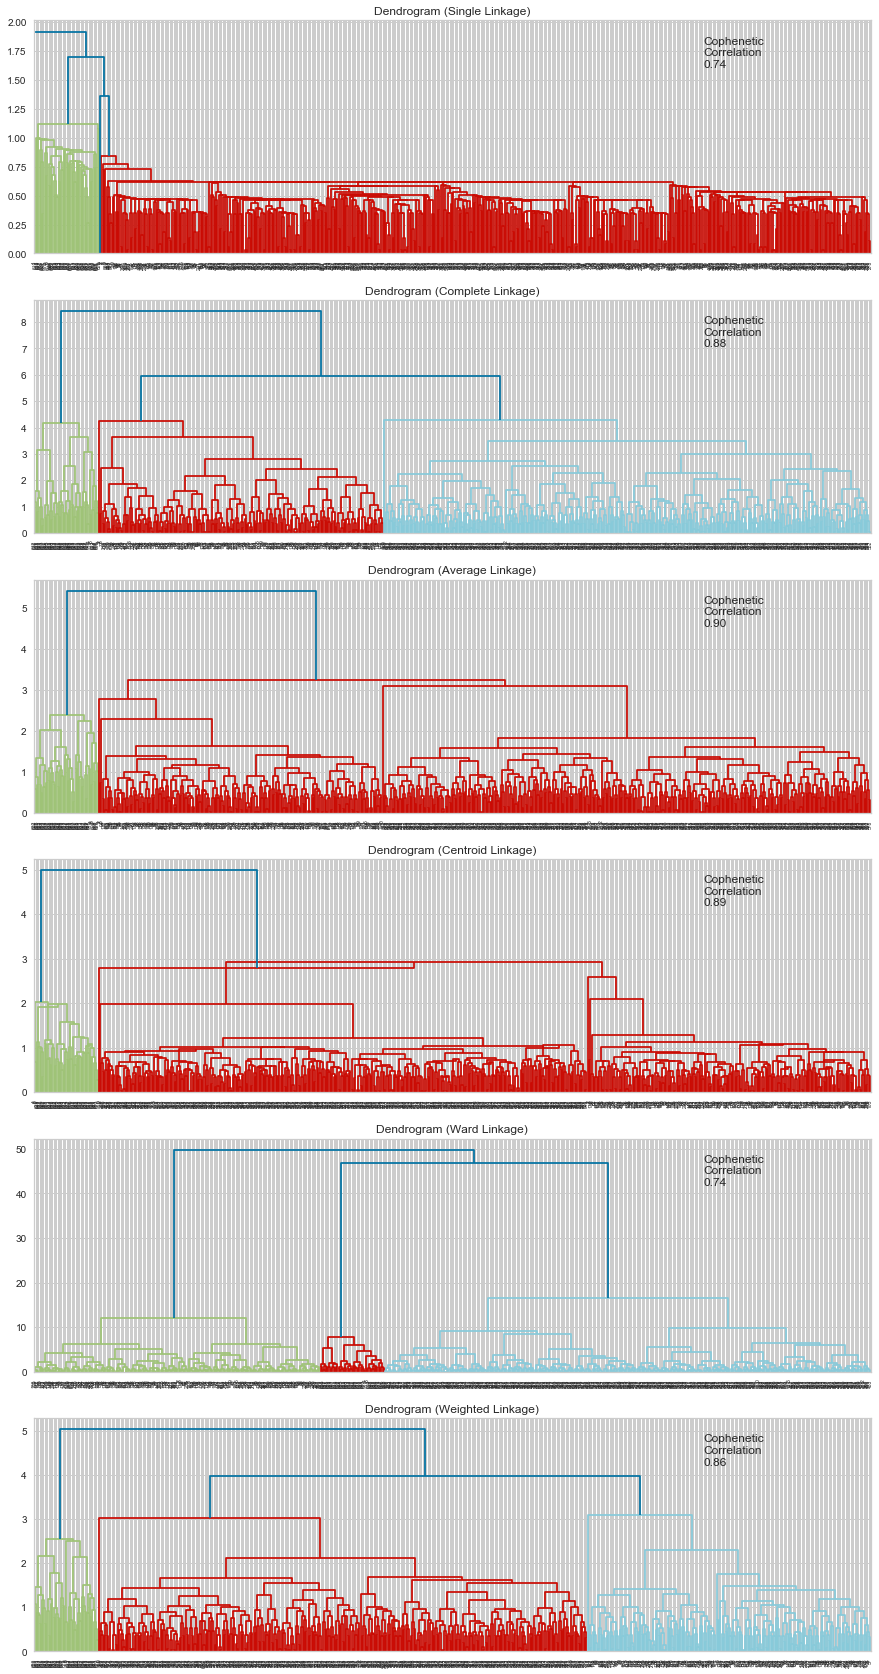

<IPython.core.display.Javascript object>

In [37]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Observations**

- Dendrogram for Complete, Ward and Weighted linkage shows distinct and separate clusters.

In [38]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.739514
1,complete,0.879474
2,average,0.897443
3,centroid,0.894471
4,ward,0.742581
5,weighted,0.855110


<IPython.core.display.Javascript object>

**Let's see the dendrogram for Mahalanobis and Manhattan distances with average and weighted linkage methods (as they gave high cophenetic correlation values).**

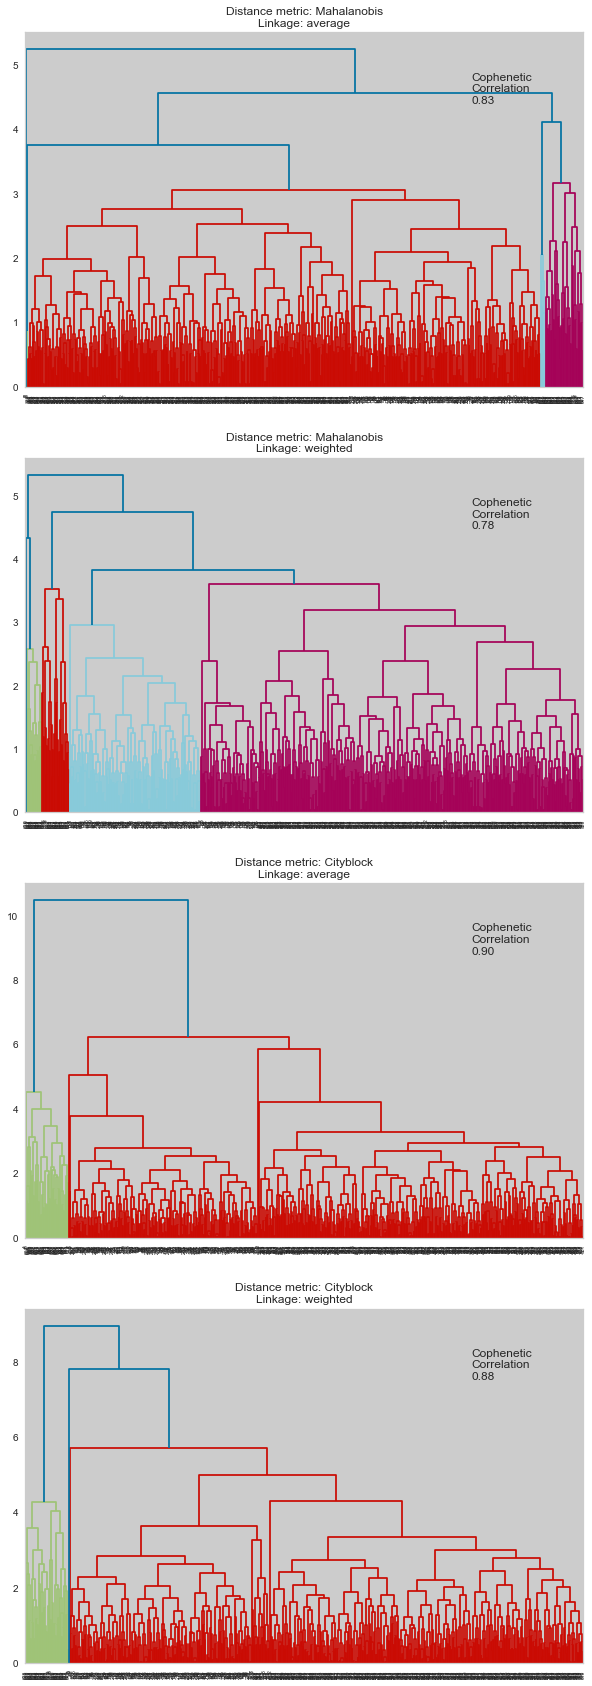

<IPython.core.display.Javascript object>

In [50]:
# list of distance metrics
distance_metrics = ["mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

**Observations**

- Out of all the dendrograms we saw, it is clear that the dendrogram with Complete linkage gave us separate and distinct clusters.
- 3 would be the appropriate number of the clusters from the dendrogram with Complete linkage method. 

**Let's create 3 clusters.**

In [52]:
HCmodel = AgglomerativeClustering(
    n_clusters=3, affinity="euclidean", linkage="complete"
)
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3)

<IPython.core.display.Javascript object>

In [53]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

## Cluster Profiling

In [54]:
cluster_profile = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [56]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [57]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,34010.582011,5.515873,3.486772,0.984127,1.992063,1.468254,378
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12343.891403,2.416290,0.941176,3.556561,6.891403,0.986425,221


<IPython.core.display.Javascript object>

## Insights

- **Cluster 0**:
    - This cluster contains people will the highest average credit limit and with an average of 5.5 credit cards. 
    - Customers in this cluster have the highest number of total visits to the bank but the lowest total visits online and total calls made. 
   

- **Cluster 1**:
    - This cluster contains people with the second highest average credit limit but the highest total number of credit cards. 
    - Total visits to the bank is lowest for customers in this cluster
    - However, people in this cluster have the highest total number of visits online. 
    

- **Cluster 2**:
    - This cluster contains customers with the lowest average credit limit and the lowest number of credit cards. Average visits to the bank is also pretty low. 
    - While the total visits online is lower than the first cluster of people, total calls made is the highest for this cluster. 

## Comparisons
- K-Means and HC methods differed in between recommending 4 and 3 clusters
- However, the clustering results between the two were not all that different. 
- Both contained clusters with customers that contained mid-level results for average credit limit and yet having the highest number of credit cards out of all the clusters. Both also contained a cluster that had the highest average credit limit but about 5 credit cards per customer. 


## Business Recommendations

- Cluster 1 contains those with the highester average credit limit and ~5 credit cards. Therefore, marketing should be done for customers that have an average of 5 credit cards plus higher visits to the bank. 